In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

In [3]:
import wave
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from util import save_wav, get_db_hz

In [4]:
# 各フィルタをバイナリ形式で開く
filter_names = ['lpf', 'bpf', 'hpf']
filter_dict = {}
for name in filter_names:
    with open('./P_file/'+ name + '.fir', 'rb') as raw:
        # d:C言語でのdouble型，<:リトルエンディアンで読み込む
        filter_dict[name] = np.fromfile(raw, dtype='<d', sep='')

In [5]:
filter_dict['hpf']

array([-2.31975571e-24,  1.15855666e-10, -5.39047081e-23, ...,
       -6.31278196e-10, -5.39047081e-23,  1.15855666e-10])

In [6]:
# バイナリ形式で開く
with open('./P_file/surround_5.1.raw', 'rb') as raw:
    # h:C言語でのshort型，<:リトルエンディアンで読み込む
    raw_data = np.fromfile(raw, dtype='<h', sep='')
    
# L(左前)，C(中央)，R(右前)，LS(左後)，RS(右後)，LFE(スーパーウーファ)
# 上記の全6ch分のデータが格納されているので，それぞれに分ける
left = raw_data[::6]
center = raw_data[1::6]
right = raw_data[2::6]
left_back = raw_data[3::6]
right_back = raw_data[4::6]
woofer = raw_data[5::6]

# 該当式によるステレオ信号を作成
L_o = ((left + 0.5 * center + 0.5 * left_back) / 2.0).astype(np.int16)
R_o = ((right + 0.5 * center + 0.5 * right_back) / 2.0).astype(np.int16)
C = ((L_o + R_o) / 2).astype(np.int16)

In [8]:
signals = []
for fir, data in filter_dict.items():
    out = []            # 畳み込み演算後の結果を格納
    offset = data.size  # フィルタのサイズ
    
    # 命名
    if fir == 'hpf':
        name = 'high-pass_filter'
    elif fir == 'lpf':
        name = 'low-pass_filter'
    else:
        name = 'band-pass_filter'
        
    # 畳み込み演算
    for i in range(C.size - offset):
        out.append((C[i:i+offset] * data).sum())
    
    # 音源の保存
    out = np.array(out).astype(np.int16)
    save_wav('./P_file/' + name + '.wav', out)
    signals.append(out)

In [9]:
low, band, high = signals

# パワースペクトルと周波数の取得
orig_db, orig_hz = get_db_hz(L_o)
low_db, low_hz = get_db_hz(low)
band_db, band_hz = get_db_hz(band)
high_db, high_hz = get_db_hz(high)

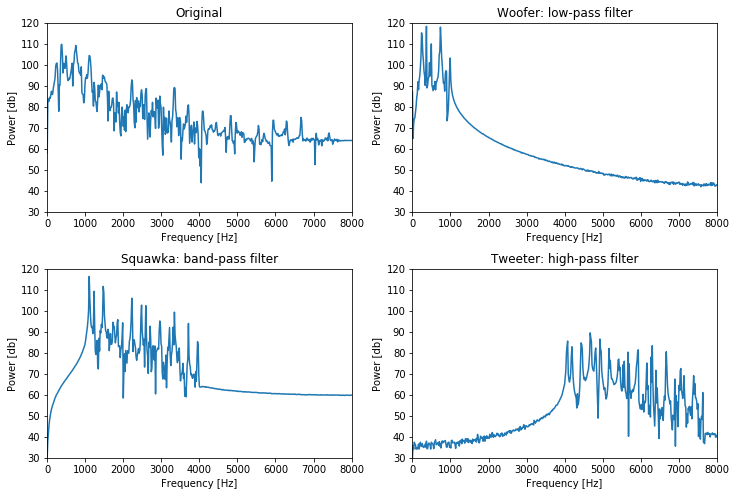

In [11]:
# 結果のプロット
plot_dict = {'Original': [orig_db, orig_hz],
             'Woofer: low-pass filter': [low_db, low_hz],
             'Squawka: band-pass filter': [band_db, band_hz],
             'Tweeter: high-pass filter': [high_db, high_hz]}

plt.figure(figsize=(12, 8))
plt.subplots_adjust(wspace=0.2, hspace=0.3)  # 余白を設定

for i in range(1, 5):
    db, hz = list(plot_dict.values())[i-1]
    plt.subplot(2, 2, i)
    plt.plot(hz, db)
    plt.xlim(0, 8000)
    plt.ylim(30, 120)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power [db]')
    plt.title(list(plot_dict.keys())[i-1])